# Experiment 5 with Regularization
Apply transfer learning to MobileNetV2 (trained on ImageNet) with data augmentation and l1 regularization

In [1]:
# model training using tensorflow
import numpy as np
import os
import cv2
from matplotlib import pyplot

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
'''
Configuration Code
'''
def get_n_cores():
    """The NSLOTS variable, If NSLOTS is not defined throw an exception."""
    nslots = os.getenv("NSLOTS")
    if nslots is not None:
        return int(nslots)
    raise ValueError("Environment variable NSLOTS is not defined.")


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

NUM_GPUS = len(tf.config.experimental.list_physical_devices("GPU"))
print("Num GPUs Available: ", NUM_GPUS)
if NUM_GPUS > 0:
    print(os.getenv("CUDA_VISIBLE_DEVICES"))

tf.config.set_soft_device_placement(True)
tf.keras.backend.set_floatx("float32")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(get_n_cores())

Num GPUs Available:  1
0


In [3]:
batch_size = 32

DATA_DIRECTORY = os.path.join(os.getcwd(), 'train_data')

size = (224,224) # height, width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 2160 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 540 files for validation.


In [6]:
'''
Set the base model to MobileNetV2 (trained on ImageNet)
'''
IMG_SHAPE = size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
# do not allow the NN to train the base network
base_model.trainable = False

In [8]:
# create the additional layers for the end
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, kernel_regularizer='l1')

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3))

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [11]:
# chain the layers together to make the complete model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
# we need a low learning rate to avoid overfitting
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
epochs=200

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/200
68/68 [==============================] - 39s 572ms/step - loss: 1.5910 - accuracy: 0.5921 - val_loss: 1.4473 - val_accuracy: 0.6722
Epoch 2/200
68/68 [==============================] - 5s 76ms/step - loss: 1.4052 - accuracy: 0.6889 - val_loss: 1.3073 - val_accuracy: 0.7593
Epoch 3/200
68/68 [==============================] - 5s 79ms/step - loss: 1.3096 - accuracy: 0.7282 - val_loss: 1.1975 - val_accuracy: 0.8056
Epoch 4/200
68/68 [==============================] - 5s 78ms/step - loss: 1.1874 - accuracy: 0.7801 - val_loss: 1.1126 - val_accuracy: 0.8352
Epoch 5/200
68/68 [==============================] - 5s 78ms/step - loss: 1.1145 - accuracy: 0.8000 - val_loss: 1.0386 - val_accuracy: 0.8500
Epoch 6/200
68/68 [==============================] - 5s 77ms/step - loss: 1.0356 - accuracy: 0.8269 - val_loss: 0.9737 - val_accuracy: 0.8593
Epoch 7/200
68/68 [==============================] - 5s 78ms/step - loss: 0.9889 - accuracy: 0.8296 - val_loss: 0.9173 - val_accuracy: 0.8685
Epoc

68/68 [==============================] - 5s 76ms/step - loss: 0.4132 - accuracy: 0.9037 - val_loss: 0.4052 - val_accuracy: 0.9148
Epoch 59/200
68/68 [==============================] - 5s 77ms/step - loss: 0.4011 - accuracy: 0.9088 - val_loss: 0.3985 - val_accuracy: 0.9185
Epoch 60/200
68/68 [==============================] - 5s 77ms/step - loss: 0.4102 - accuracy: 0.9023 - val_loss: 0.3992 - val_accuracy: 0.9167
Epoch 61/200
68/68 [==============================] - 5s 77ms/step - loss: 0.3979 - accuracy: 0.9093 - val_loss: 0.3949 - val_accuracy: 0.9222
Epoch 62/200
68/68 [==============================] - 5s 78ms/step - loss: 0.3999 - accuracy: 0.9079 - val_loss: 0.3970 - val_accuracy: 0.9185
Epoch 63/200
68/68 [==============================] - 5s 80ms/step - loss: 0.3995 - accuracy: 0.9130 - val_loss: 0.3993 - val_accuracy: 0.9167
Epoch 64/200
68/68 [==============================] - 9s 134ms/step - loss: 0.3942 - accuracy: 0.9139 - val_loss: 0.3923 - val_accuracy: 0.9185
Epoch 65/20

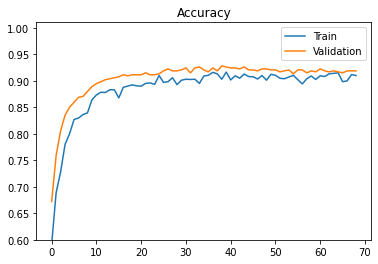

In [14]:
'''
Plot the accuracy
'''
pyplot.title("Accuracy")
pyplot.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = "Train")
pyplot.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = "Validation")
pyplot.ylim((0.6, 1.01))
pyplot.legend()
pyplot.show()

In [15]:
# save the model
model.save("models/{}".format("experiment_005ra"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/experiment_005ra/assets


In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

Fine-tuning can hopefully improve the model still. The last 50 layers of MobileNetV2 will be unlocked to allow for gradient adjustments

In [17]:
# change to fine tuning
base_model.trainable = True

# this is the layer to start fine tuning at
fine_tune_at = len(base_model.layers) - 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [18]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [19]:
fine_tune_epochs = 150
total_epochs =  history.epoch[-1] + fine_tune_epochs

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks = [callback]
)


Epoch 69/218
68/68 [==============================] - 7s 101ms/step - loss: 0.3766 - accuracy: 0.9120 - val_loss: 0.3610 - val_accuracy: 0.9241
Epoch 70/218
68/68 [==============================] - 6s 85ms/step - loss: 0.3504 - accuracy: 0.9199 - val_loss: 0.3422 - val_accuracy: 0.9259
Epoch 71/218
68/68 [==============================] - 6s 87ms/step - loss: 0.3358 - accuracy: 0.9264 - val_loss: 0.3292 - val_accuracy: 0.9241
Epoch 72/218
68/68 [==============================] - 6s 85ms/step - loss: 0.3319 - accuracy: 0.9227 - val_loss: 0.3317 - val_accuracy: 0.9167
Epoch 73/218
68/68 [==============================] - 6s 90ms/step - loss: 0.3257 - accuracy: 0.9319 - val_loss: 0.3153 - val_accuracy: 0.9278
Epoch 74/218
68/68 [==============================] - 6s 89ms/step - loss: 0.3192 - accuracy: 0.9306 - val_loss: 0.3138 - val_accuracy: 0.9278
Epoch 75/218
68/68 [==============================] - 10s 148ms/step - loss: 0.3049 - accuracy: 0.9347 - val_loss: 0.3127 - val_accuracy: 0.9

68/68 [==============================] - 6s 95ms/step - loss: 0.1722 - accuracy: 0.9838 - val_loss: 0.2005 - val_accuracy: 0.9667
Epoch 127/218
68/68 [==============================] - 7s 102ms/step - loss: 0.1883 - accuracy: 0.9778 - val_loss: 0.2024 - val_accuracy: 0.9685
Epoch 128/218
68/68 [==============================] - 9s 134ms/step - loss: 0.1881 - accuracy: 0.9778 - val_loss: 0.2015 - val_accuracy: 0.9648
Epoch 129/218
68/68 [==============================] - 12s 170ms/step - loss: 0.1837 - accuracy: 0.9792 - val_loss: 0.1991 - val_accuracy: 0.9685
Epoch 130/218
68/68 [==============================] - 6s 86ms/step - loss: 0.1844 - accuracy: 0.9778 - val_loss: 0.1985 - val_accuracy: 0.9704
Epoch 131/218
68/68 [==============================] - 6s 92ms/step - loss: 0.1913 - accuracy: 0.9764 - val_loss: 0.1964 - val_accuracy: 0.9722
Epoch 132/218
68/68 [==============================] - 8s 112ms/step - loss: 0.1785 - accuracy: 0.9833 - val_loss: 0.1949 - val_accuracy: 0.9704
E

Epoch 183/218
68/68 [==============================] - 6s 86ms/step - loss: 0.1481 - accuracy: 0.9894 - val_loss: 0.1573 - val_accuracy: 0.9833
Epoch 184/218
68/68 [==============================] - 6s 87ms/step - loss: 0.1482 - accuracy: 0.9926 - val_loss: 0.1573 - val_accuracy: 0.9852
Epoch 185/218
68/68 [==============================] - 6s 87ms/step - loss: 0.1511 - accuracy: 0.9880 - val_loss: 0.1571 - val_accuracy: 0.9852
Epoch 186/218
68/68 [==============================] - 6s 86ms/step - loss: 0.1444 - accuracy: 0.9935 - val_loss: 0.1593 - val_accuracy: 0.9852
Epoch 187/218
68/68 [==============================] - 6s 87ms/step - loss: 0.1512 - accuracy: 0.9894 - val_loss: 0.1563 - val_accuracy: 0.9833
Epoch 188/218
68/68 [==============================] - 6s 88ms/step - loss: 0.1468 - accuracy: 0.9907 - val_loss: 0.1561 - val_accuracy: 0.9833
Epoch 189/218
68/68 [==============================] - 6s 86ms/step - loss: 0.1457 - accuracy: 0.9907 - val_loss: 0.1554 - val_accuracy:

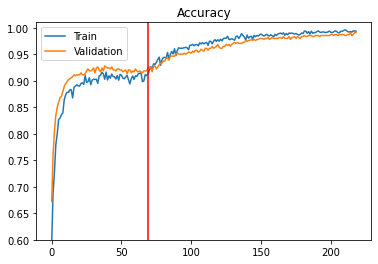

In [20]:
'''
Plot the total accuracy
'''
n = len(history.history['accuracy']) + len(history_fine.history['accuracy'])

pyplot.title("Accuracy")
pyplot.plot(range(n), history.history['accuracy'] + history_fine.history['accuracy'], label = "Train")
pyplot.plot(range(n), history.history['val_accuracy'] + history_fine.history['val_accuracy'], label = "Validation")

pyplot.axvline(x=len(history.history['loss']), color='red')
pyplot.ylim((0.6,1.01))
pyplot.legend()
pyplot.show()


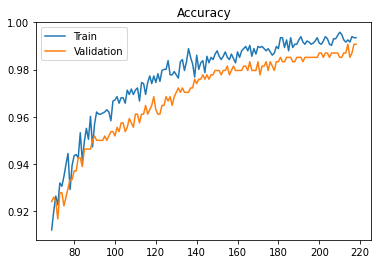

In [21]:
'''
Plot the fine tuning accuracy
'''
a = len(history.history['accuracy'])
b = len(history_fine.history['accuracy'])
c = a+b

pyplot.title("Accuracy")
pyplot.plot(range(a,c), history_fine.history['accuracy'], label = "Train")
pyplot.plot(range(a,c), history_fine.history['val_accuracy'], label = "Validation")
pyplot.legend()
pyplot.show()


In [22]:
model.save('models/experiment_005rb')

INFO:tensorflow:Assets written to: models/experiment_005rb/assets
